# Feature Extraction

## Instructions
1. Download the attached file to the assingment and save it in your google drive folder.
2. Read the intoduction
3. Follow the instructions and run cell by cell
4. Fill the code where you see (...)

## Feature Extraction From Time Series Data

In this exercise, you will extract spectral features from time-series data.

### What is Time Series Data?

Time series data is a sequence of data points recorded at successive time intervals. This type of data captures how values evolve over time, making it suitable for studying dynamic processes.

**In the context of animal behavior, time series data can include:**

1. Movement data: Acceleration and position data from wearable sensors on animals (e.g., GPS or accelerometers).
2. Vocalization data: Audio recordings of animal sounds, such as calls or vocal patterns.
3. Physiological signals: Data from heart rate, respiration, or muscle activity during various behaviors.

For example, you might track how the acceleration of a bird's flight changes over time, or how the vocalizations of a rat vary during sniffing. These kinds of data provide valuable insights into patterns and behaviors that can be quantitatively analyzed.

### Common Features Extracted from Time Series Data

When working with time-series data, we often extract various features that help capture meaningful information about the underlying patterns. These features are used both in unsupervised learning (such as clustering) and supervised learning (such as classification).

Some commonly extracted features include:

  1. Statistical Features:

        Mean, standard deviation, and variance of the signal
        Minimum, maximum, and range
        Autocorrelation to measure how values are related over time
  2. Frequency Domain Features:

        Fourier Transform: Converts time-domain data into frequency-domain data, revealing the dominant frequencies in the signal.
        Power Spectral Density (PSD): Shows the power distribution across different frequencies in the signal.
  3. Wavelet Features:

        Continuous Wavelet Transform (CWT): Captures both frequency and time information, useful for non-stationary signals where patterns change over time.

These features help uncover patterns, trends, and behaviors that may not be immediately visible in the raw time series data.
Features We Will Extract in This Exercise

### The Data
In this example, we will explore the breathing patterns of rats during social interactions with another rat.

**The experiment consists of three phases:**

1. Pre-encounter: A 5-minute period where the subject rat is placed in an empty cage for habituation.
2. Encounter: A 5-minute period where a second rat (referred to as the stimulus rat) is placed in the cage, confined within a small chamber to prevent direct contact with the subject rat.
3. Post-encounter: A 5-minute period after the stimulus rat is removed, leaving the subject rat alone in the cage again.

Throughout the experiment, the breathing patterns of the subject rat were recorded using a pressure sensor attached to a tube implanted in the rat's nose.

**In this example, we will focus on two spectral features:**

1. Linear Spectrogram:
 The spectrogram is a time-varying representation of the signal’s frequency content. It allows us to see how the frequency components evolve over time.

2. Continuous Wavelet Transform (CWT):
 The CWT is a more advanced method that provides both time and frequency resolution, making it well-suited for analyzing non-stationary signals like those found in animal behavior data. It gives a multi-scale view of the data, showing how the signal behaves across different frequency bands over time.

By extracting these features, we can capture important patterns that may not be apparent in the raw data but are crucial for understanding animal behaviors.



## Preparations

In [2]:

import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pywt
from sklearn.cluster import KMeans

## Load data and subsample

1. Mount the google drive
2. Load the data from the drive
3. Downsample the data

The data was sampled at 5000 Hz (samples per second), but the breathing patterns of rats that we are trying to invesitage peak around 20 Hz (20 breaths per second), therefore we can safely reduce the sampling rate without worries.

We will downsample the data from the original sr=5000 Hz to sr=100 Hz


In [3]:
# Set the path and load

mat_file_path = './Rat2-day1-male-Free-sniffing.mat'
mat_data = scipy.io.loadmat(mat_file_path)

if 'SniffingDataAt5000Hz' in mat_data:
    SniffingDataAt5000Hz = mat_data['SniffingDataAt5000Hz'].squeeze()  # Remove any extra dimensions
    print("Data successfully loaded.")
else:
    print("SniffingDataAt5000Hz not found in the .mat file.")


Data successfully loaded.


In [4]:
# Downsample the data


# Set original and new sampling frequencies
orig_fs = 5000  # Original sampling frequency (Hz)
new_fs = 100     # New sampling frequency (Hz)

# Step 6: Downsample the data
vec_down = librosa.resample(SniffingDataAt5000Hz, orig_sr=orig_fs, target_sr=new_fs)[1:] # I removed the first element because it was on the egde, you can make this better by using a better window

time_vector = np.arange(0, len(vec_down) / new_fs, 1 / new_fs)


## Visualize the Raw Data

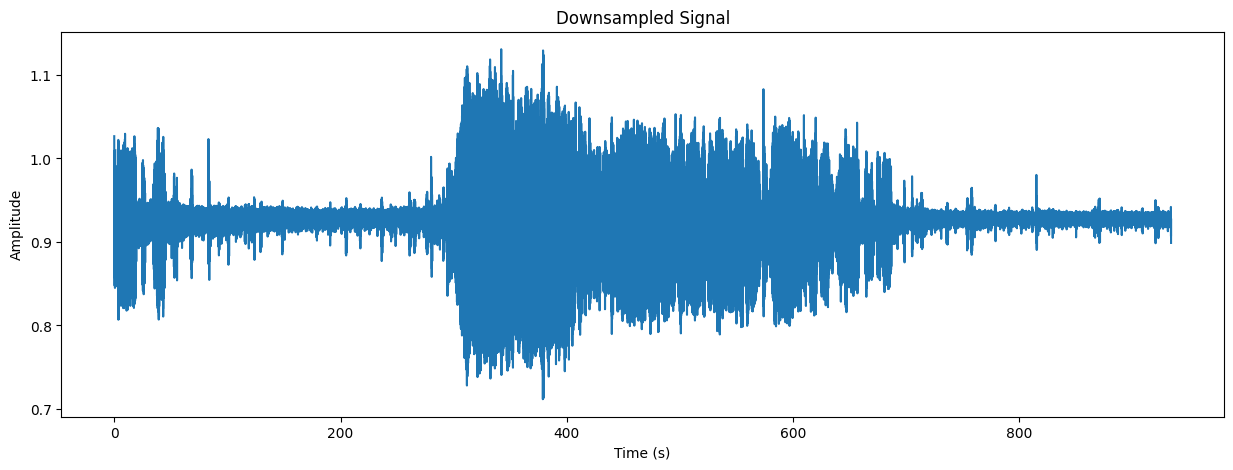

In [5]:
# Plot the downsampled signal
plt.figure(figsize=(15,5))
plt.plot(time_vector,vec_down)
plt.title('Downsampled Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

We can't get a lot of information from the raw signal alone, however, we can see that there are three distict patterns in the breathing data,

Let's visualize a small segment in each experimental stage:

1. Stage 1: 0-300 seconds (habituation)
2. Stage 2: 300-600 seconds (encounter)
3. Stage 3: 600-900 (post encounter)

Sample a short 5 second segment from each stage and visualize

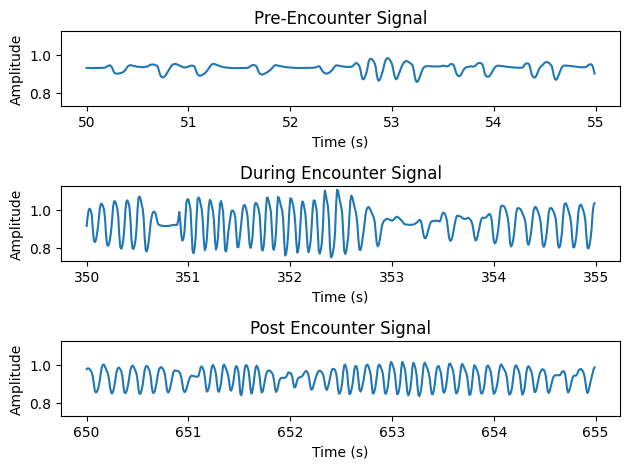

In [44]:
fig, axis = plt.subplots(3,1,sharex=False, sharey=True)
fig.figsize = (15,10)
# first stage
time_range = [50,55]
seg = [int(new_fs*time_range[0]),int(new_fs*time_range[1])]
axis[0].plot(time_vector[seg[0]:seg[1]],vec_down[seg[0]:seg[1]])
axis[0].set_title('Pre-Encounter Signal')
axis[0].set_xlabel('Time (s)')
axis[0].set_ylabel('Amplitude')

# second stage
time_range = [350,355] # <= Complete code here
seg = [int(new_fs*time_range[0]),int(new_fs*time_range[1])]
axis[1].plot(time_vector[seg[0]:seg[1]],vec_down[seg[0]:seg[1]])
axis[1].set_title('During Encounter Signal')
axis[1].set_xlabel('Time (s)')
axis[1].set_ylabel('Amplitude')

# third stage
time_range = (650,655) # <= Complete code here
seg = [int(new_fs*time_range[0]),int(new_fs*time_range[1])]
axis[2].plot(time_vector[seg[0]:seg[1]],vec_down[seg[0]:seg[1]])
axis[2].set_title('Post Encounter Signal') # <= Complete code here
axis[2].set_xlabel('Time (s)') # <= Complete code here
axis[2].set_ylabel('Amplitude') # <= Complete code here

fig.tight_layout()

plt.show()

## Extract Spectral Features

To be able to analyze time series, we need extract features that use the change over time into account.

One such feature is the linear spectrogram, which converts the signal from time-amplitude into the domain of time-frequency.


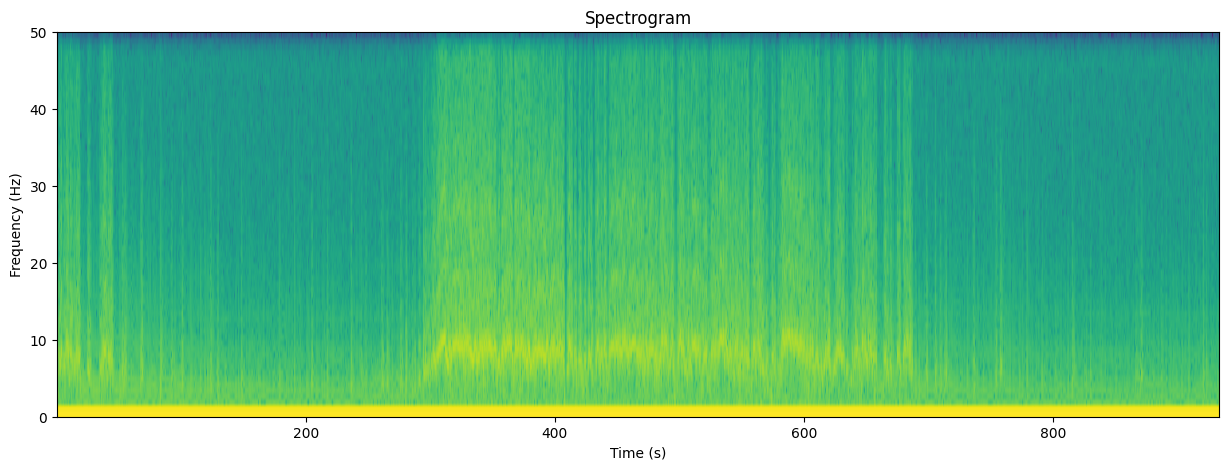

In [9]:
# Create a spectrogram of the downsampled signal
plt.figure(figsize=(15,5))
plt.specgram(vec_down, NFFT=128, Fs=new_fs, noverlap=64)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram')
plt.show()

In the spectrogram above, we can observe that the X-axis still represents time, while the Y-axis now represents frequency.

In a spectrogram, each row corresponds to a different frequency, and the color intensity indicates the magnitude of the signal at a given time and frequency.

From this spectrogram, we can see that the frequency during the pre-encounter and post-encounter phases is lower compared to the encounter phase. This is expected—when the subject rat is exposed to the stimulus rat, it exhibits investigative behavior by sniffing more rapidly.

However, we also notice that the lower frequencies appear as a single yellow band. This highlights one limitation of linear spectrograms: the frequency range is restricted. While it is possible to adjust the spectrogram to better visualize lower frequencies, this often results in a loss of clarity for higher frequencies.

In many cases, we are only concerned with a narrower frequency band, but in this instance, a wider range is required.

To address this limitation, there are other spectral features we can utilize, such as the mel-spectrogram, which extracts features using a scale that mimics human auditory perception, providing better resolution for lower frequencies. Another option is the continuous wavelet transform (CWT), which applies different scales for each frequency, allowing for a more flexible analysis of both low and high-frequency components across time.


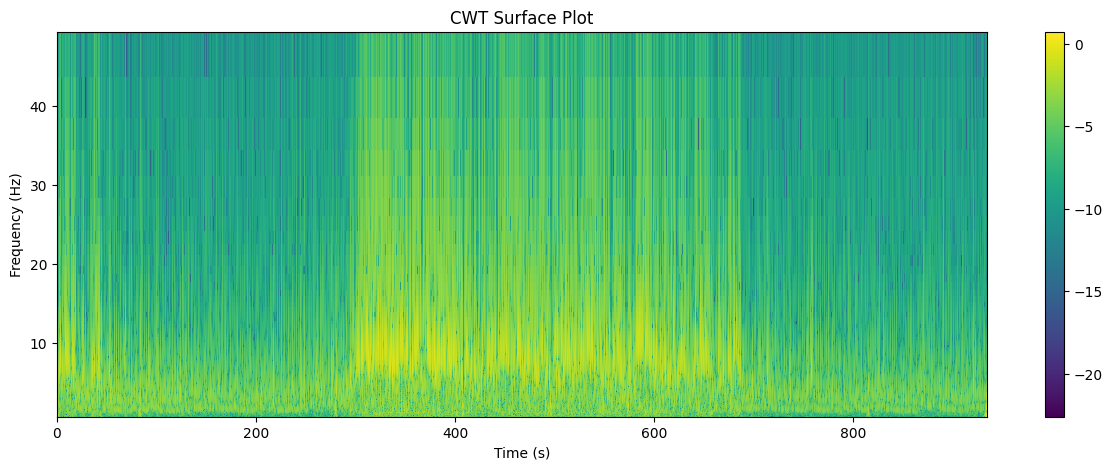

In [10]:
# Perform Continuous Wavelet Transform (CWT)
fb = pywt.ContinuousWavelet('morl')  # Using Morlet wavelet
scales = np.linspace(1, 128, 512)
cfs, freqs = pywt.cwt(vec_down, scales, fb, sampling_period=1/new_fs)

# Convert cfs to absolute values
cfs = np.log(np.abs(cfs)+1e-10)

# Step 10: Create a time vector for plotting
t_vec = np.arange(len(vec_down)) / new_fs

# Filter frequencies within the desired range
min_freq = 0.5
max_freq = 50
freqs_in_range = (freqs >= min_freq) & (freqs <= max_freq)
filtered_cfs = cfs[freqs_in_range, :]
filtered_freqs = freqs[freqs_in_range]

# Step 11: Plot the CWT as a surface plot
plt.figure(figsize=(15,5))
plt.pcolormesh(t_vec, filtered_freqs, filtered_cfs, shading='auto')
plt.colorbar()
plt.title('CWT Surface Plot')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

## Cluster the Data

After extracting the spectral features, we can proceed by identifying the maximum frequency at each time point. One approach is to apply a simple threshold to distinguish between different breathing patterns. Alternatively, we can use clustering techniques to automatically separate different frequency patterns over time.

In the next session, we will explore clustering in more detail. For now, think of clustering as an unsupervised method that groups samples based on their similarity, allowing us to classify the frequency patterns without prior labels.

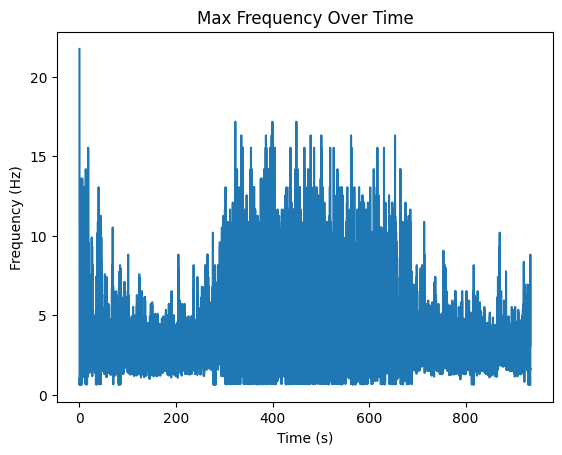

In [11]:

# Find the maximum frequency value along each time step
max_freq_ind = np.argmax(cfs, axis=0)
max_freq = freqs[max_freq_ind]

# Plot the maximum frequency over time
plt.figure()
plt.plot(t_vec, max_freq)
plt.title('Max Frequency Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()



Let's make a plot for each stage

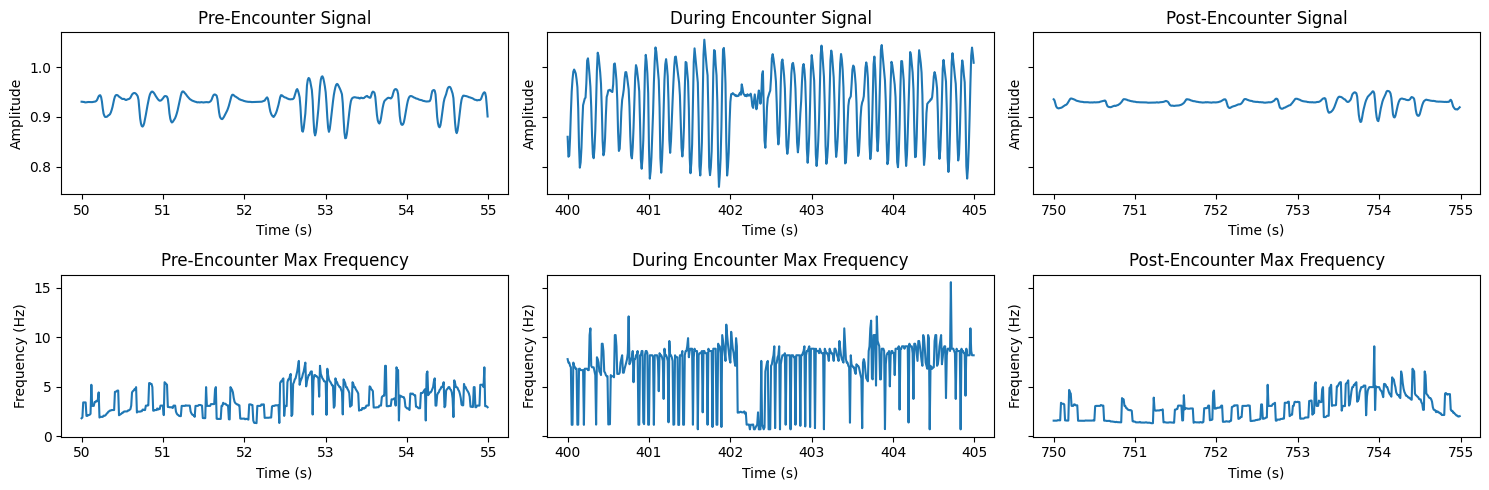

In [12]:
fig, axis = plt.subplots(2, 3, figsize=(15, 5), sharex=False, sharey='row')

# First stage (Pre-encounter)
time_range = [50, 55]  # 5-second segment
seg = [int(new_fs*time_range[0]), int(new_fs*time_range[1])]
axis[0, 0].plot(t_vec[seg[0]:seg[1]], vec_down[seg[0]:seg[1]])
axis[0, 0].set_title('Pre-Encounter Signal')
axis[0, 0].set_xlabel('Time (s)')
axis[0, 0].set_ylabel('Amplitude')

axis[1, 0].plot(t_vec[seg[0]:seg[1]], max_freq[seg[0]:seg[1]])
axis[1, 0].set_title('Pre-Encounter Max Frequency')
axis[1, 0].set_xlabel('Time (s)')
axis[1, 0].set_ylabel('Frequency (Hz)')

# Second stage (During Encounter)
time_range = [400, 405]  # Adjust to your time range for the encounter stage
seg = [int(new_fs*time_range[0]), int(new_fs*time_range[1])]
axis[0, 1].plot(t_vec[seg[0]:seg[1]], vec_down[seg[0]:seg[1]])
axis[0, 1].set_title('During Encounter Signal')
axis[0, 1].set_xlabel('Time (s)')
axis[0, 1].set_ylabel('Amplitude')

axis[1, 1].plot(t_vec[seg[0]:seg[1]], max_freq[seg[0]:seg[1]])
axis[1, 1].set_title('During Encounter Max Frequency')
axis[1, 1].set_xlabel('Time (s)')
axis[1, 1].set_ylabel('Frequency (Hz)')

# Third stage (Post-encounter)
time_range = [750, 755]  # Adjust to your time range for post-encounter stage
seg = [int(new_fs*time_range[0]), int(new_fs*time_range[1])]
axis[0, 2].plot(t_vec[seg[0]:seg[1]], vec_down[seg[0]:seg[1]])
axis[0, 2].set_title('Post-Encounter Signal')
axis[0, 2].set_xlabel('Time (s)')
axis[0, 2].set_ylabel('Amplitude')

axis[1, 2].plot(t_vec[seg[0]:seg[1]], max_freq[seg[0]:seg[1]])
axis[1, 2].set_title('Post-Encounter Max Frequency')
axis[1, 2].set_xlabel('Time (s)')
axis[1, 2].set_ylabel('Frequency (Hz)')

# Adjust layout
fig.tight_layout()
plt.show()


Next We will cluster the data based on the cwt values for the first 30 frequencies.

In [13]:
# K-means clustering on the first 30 frequency bands
kmeans = KMeans(n_clusters=3, random_state=0).fit(cfs[:30, :].T)
ret = kmeans.labels_

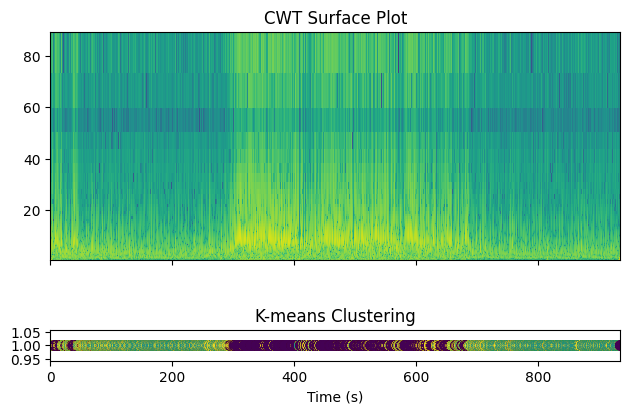

In [43]:
# Combined plot of CWT and K-means clustering
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot CWT
ax1.pcolormesh(t_vec, freqs, cfs, shading='auto')
ax1.set_title('CWT Surface Plot')

# Plot K-means clustering results
ax2.scatter(t_vec, np.ones_like(t_vec), c=ret, cmap='viridis')
ax2.set_title('K-means Clustering')
ax2.set_box_aspect(aspect=50/max(t_vec))

plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

In [ ]:


# Create subplots with 2 rows and 3 columns for the 3 stages, with height ratios 80% (upper), 20% (lower)
fig, axis = plt.subplots(2, 3, figsize=(15, 5), sharex=False, sharey='row',
                         gridspec_kw={'height_ratios': [4, 1]})  # 4:1 ratio (80% and 20%)

# First stage (Pre-encounter)
time_range = [50, 55]  # 5-second segment
seg = [int(new_fs*time_range[0]), int(new_fs*time_range[1])]

# Plot CWT for pre-encounter
axis[0, 0].pcolormesh ... # <- Continue code
axis[0, 0].set_title('Pre-Encounter CWT')
axis[0, 0].set_xlabel('Time (s)')
axis[0, 0].set_ylabel('Frequency (Hz)')
axis[0, 0].set_ylim([0.5, 30])

# Plot K-means clustering results for pre-encounter
axis[1, 0].scatter(t_vec[seg[0]:seg[1]], np.ones_like(t_vec[seg[0]:seg[1]]), c=ret[seg[0]:seg[1]], cmap='viridis')
axis[1, 0].set_title('Pre-Encounter K-means Clustering')
axis[1, 0].set_xlabel('Time (s)')
axis[1, 0].set_ylabel('Cluster')

# Second stage (During Encounter)
time_range = [400, 405]  # 5-second segment during encounter
seg = [int(new_fs*time_range[0]), int(new_fs*time_range[1])]

# Plot CWT for during encounter
axis[0, 1].pcolormesh(t_vec[seg[0]:seg[1]], freqs, cfs[:, seg[0]:seg[1]], shading='auto')
axis[0, 1].set_title('During Encounter CWT')
axis[0, 1].set_xlabel('Time (s)')
axis[0, 1].set_ylabel('Frequency (Hz)')
axis[0, 1].set_ylim([0.5, 30])


# Plot K-means clustering results for during encounter
axis[1, 1].scatter(t_vec[seg[0]:seg[1]], np.ones_like(t_vec[seg[0]:seg[1]]), c=ret[seg[0]:seg[1]], cmap='viridis')
axis[1, 1].set_title('During Encounter K-means Clustering')
axis[1, 1].set_xlabel('Time (s)')
axis[1, 1].set_ylabel('Cluster')


# Third stage (Post-encounter)
time_range = [750, 755]  # 5-second segment post-encounter
seg = [int(new_fs*time_range[0]), int(new_fs*time_range[1])]

# Plot CWT for post-encounter
axis[0, 2].pcolormesh ... # <- Continue code
axis[0, 2].set_title('Post-Encounter CWT')
axis[0, 2].set_xlabel('Time (s)')
axis[0, 2].set_ylabel('Frequency (Hz)')
axis[0, 2].set_ylim([0.5, 30])

# Plot K-means clustering results for post-encounter
axis[1, 2].scatter(t_vec[seg[0]:seg[1]], np.ones_like(t_vec[seg[0]:seg[1]]), c=ret[seg[0]:seg[1]], cmap='viridis')
axis[1, 2].set_title('Post-Encounter K-means Clustering')
axis[1, 2].set_xlabel('Time (s)')
axis[1, 2].set_ylabel('Cluster')

# Adjust layout
fig.tight_layout()
plt.show()


In [ ]:
# axis[0, 0].pcolormesh(t_vec[seg[0]:seg[1]], freqs, cfs[:, seg[0]:seg[1]], shading='auto')
# axis[0, 2].pcolormesh(t_vec[seg[0]:seg[1]], freqs, cfs[:, seg[0]:seg[1]], shading='auto')